In [111]:
#import libraries
import ulmo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, Flatten, Dense


In [112]:
# Mapping parameter codes to readable names
param_labels = {
    '00054:00001': 'Reservoir storage (mean)',
    '00054:00002': 'Reservoir storage (max)',
    '00054:00003': 'Reservoir storage (min)',
    '00054:32400': 'Reservoir storage (instantaneous)',
    '62614:00001': 'Reservoir elevation (mean)',
    '62614:00002': 'Reservoir elevation (max)',
    '62614:00003': 'Reservoir elevation (min)',
    '62614:32400': 'Reservoir elevation (instantaneous)',
    '00035:00000': 'Water temperature (°C)',
    '00036:00000': 'Air temperature (°C)',
    '00045:00000': 'Precipitation (in)',
    '62614:00000': 'Reservoir elevation (default)'
}

site_code = '08067600' 
start_date = '2010-01-01'
end_date = '2021-4-30'

In [113]:
# data from ulmo api
parameter_keys = list(param_labels.keys())
frames = []

site_data = ulmo.usgs.nwis.get_site_data(
    site_code, start=start_date, end=end_date, methods='all'
)

for key in parameter_keys:
    if key in site_data:
        values = site_data[key].get('values', [])
        if values:
            df = pd.DataFrame(values)
            df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_localize(None)
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            df['parameter'] = param_labels.get(key, key)
            frames.append(df)
df.columns
df.head()

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=08067600&startDT=2010-01-01&endDT=2021-04-30
processing data from request: https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml&site=08067600&startDT=2010-01-01T00%3A00%3A00&endDT=2021-04-30T00%3A00%3A00


,value,qualifiers,datetime,parameter
0,201.16,A,2010-01-01,Reservoir elevation (min)
1,201.14,A,2010-01-02,Reservoir elevation (min)
2,201.13,A,2010-01-03,Reservoir elevation (min)
3,201.15,A,2010-01-04,Reservoir elevation (min)
4,201.10,A,2010-01-05,Reservoir elevation (min)


In [114]:
result_df = pd.concat(frames, ignore_index=True)
wide_df = result_df.pivot_table(index='datetime', columns='parameter', values='value')
wide_df = wide_df.reset_index()
wide_df = wide_df.groupby('datetime', as_index=False).mean()

print(wide_df.head(20))

parameter   datetime  Reservoir elevation (min)  Reservoir storage (min)
0         2010-01-01                     201.16                 419500.0
1         2010-01-02                     201.14                 419000.0
2         2010-01-03                     201.13                 418900.0
3         2010-01-04                     201.15                 419200.0
4         2010-01-05                     201.10                 418200.0
5         2010-01-06                     201.07                 417700.0
6         2010-01-07                     201.14                 419100.0
7         2010-01-08                     201.09                 418100.0
8         2010-01-09                     201.04                 417000.0
9         2010-01-10                     201.02                 416500.0
10        2010-01-11                     201.02                 416600.0
11        2010-01-12                     201.02                 416700.0
12        2010-01-13                     201.02    

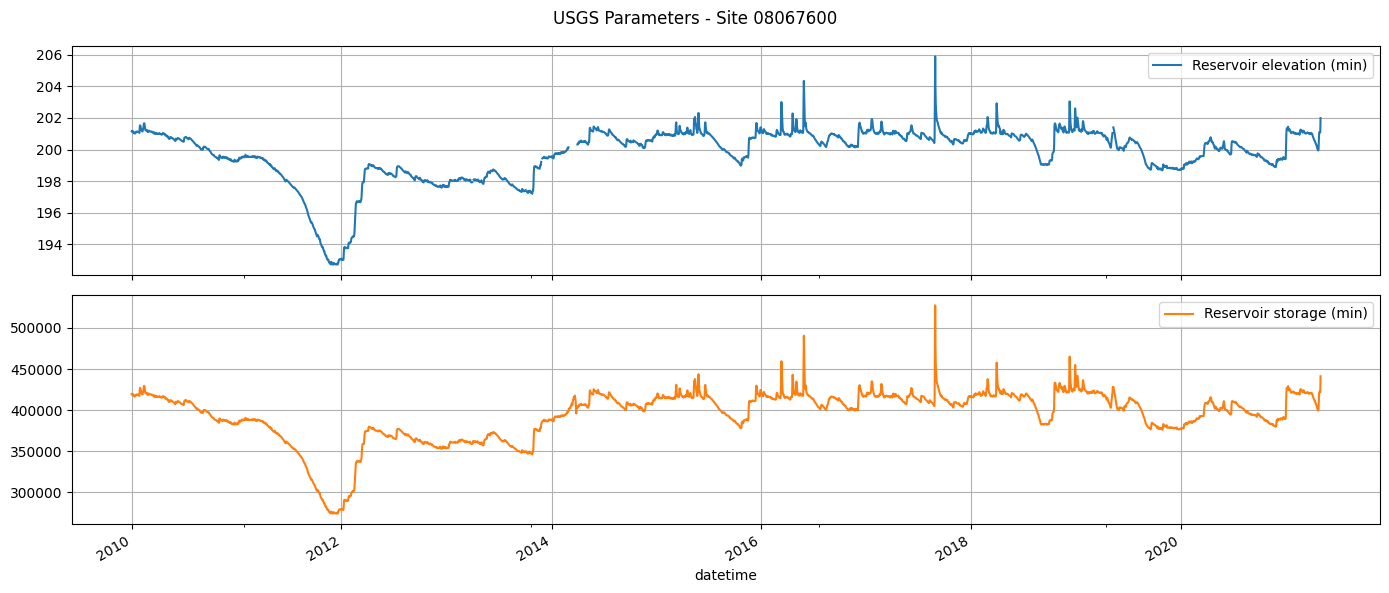

In [115]:
# Plot each parameter
wide_df.set_index('datetime').plot(subplots=True, figsize=(14, len(wide_df.columns)*2),grid=True, title='USGS Parameters - Site 08067600')
plt.tight_layout()
plt.show()

In [116]:
# Load the CSV file
csv_df = pd.read_csv('08067600_LakeConroe.csv')  
csv_df.columns = ['date', 'cs_storage', 'precip', 'avg_temp']
csv_df['date'] = pd.to_datetime(csv_df['date'])
csv_df.head()

,date,cs_storage,precip,avg_temp
0,2010-01-01,419375.852,0.014457,49.368683
1,2010-01-02,418974.948,0.000000,42.533200
2,2010-01-03,418774.496,0.000000,43.031429
3,2010-01-04,419175.400,0.000000,41.572904
4,2010-01-05,418173.140,0.000000,35.167691


In [117]:
#check for missing values
print(csv_df.isnull().sum())

date          0
cs_storage    0
precip        0
avg_temp      0
dtype: int64


In [118]:
merged_df = pd.merge(wide_df, csv_df[['date', 'precip', 'avg_temp']], left_on='datetime', right_on='date', how='inner')
merged_df.drop(columns=['date'], inplace=True)
merged_df.rename(columns={'avg_temp': 'temperature'}, inplace=True)
print(merged_df.head())

    datetime  Reservoir elevation (min)  Reservoir storage (min)    precip  \
0 2010-01-01                     201.16                 419500.0  0.014457   
1 2010-01-02                     201.14                 419000.0  0.000000   
2 2010-01-03                     201.13                 418900.0  0.000000   
3 2010-01-04                     201.15                 419200.0  0.000000   
4 2010-01-05                     201.10                 418200.0  0.000000   

   temperature  
0    49.368683  
1    42.533200  
2    43.031429  
3    41.572904  
4    35.167691  


In [119]:
# Summary stats
print(merged_df.describe())

# Check missing values
print(merged_df.isnull().sum())

       Reservoir elevation (min)  Reservoir storage (min)       precip  \
count                4094.000000              4136.000000  4136.000000   
mean                  199.751045            394176.571567     0.137230   
std                     1.701628             30911.941552     0.444631   
min                   192.720000            274000.000000     0.000000   
25%                   198.950000            379175.000000     0.000000   
50%                   200.310000            404100.000000     0.000065   
75%                   200.980000            416400.000000     0.057320   
max                   205.890000            527600.000000     9.840724   

       temperature  
count  4136.000000  
mean     68.384513  
std      14.176075  
min      14.859177  
25%      57.817977  
50%      70.896098  
75%      80.991524  
max      90.790719  
datetime                      0
Reservoir elevation (min)    42
Reservoir storage (min)       0
precip                        0
temperature     

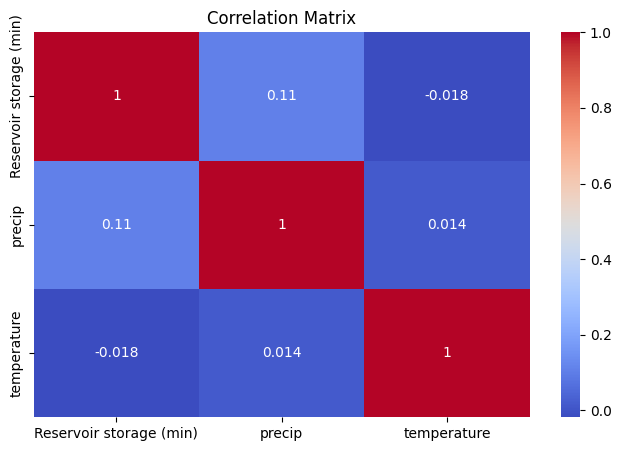

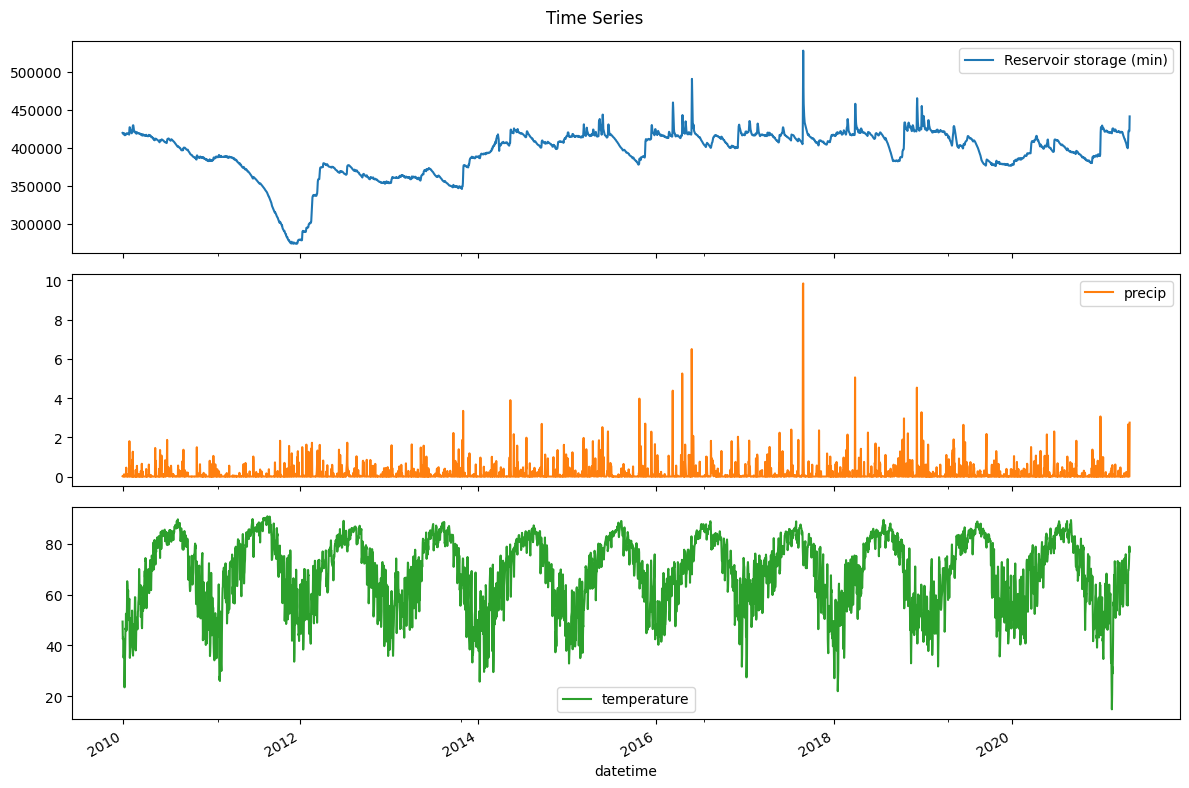

In [120]:
# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(merged_df[['Reservoir storage (min)', 'precip', 'temperature']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Line plots
merged_df.set_index('datetime')[['Reservoir storage (min)', 'precip', 'temperature']].plot(subplots=True, figsize=(12, 8), title='Time Series')
plt.tight_layout()
plt.show()

In [121]:
# Sort and select features
merged_df = merged_df.sort_values('datetime')
features = ['precip', 'temperature']
target = 'Reservoir storage (min)'

# Split train/test
train_df = merged_df[merged_df['datetime'] <= '2021-04-20']
test_df = merged_df[merged_df['datetime'] > '2021-04-20']

X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values


In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [123]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

# Evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse_lr)


Linear Regression MAE: 19402.332224154
Linear Regression RMSE: 22689.730599409213


In [124]:
# Reshape input for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [125]:
# Build CNN model
cnn_model = Sequential([
    InputLayer(input_shape=(X_train_cnn.shape[1], 1)),
    Conv1D(32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse')

/Users/duthie/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [126]:
# Train model
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, verbose=0)

# Predict and evaluate
y_pred_cnn = cnn_model.predict(X_test_cnn).flatten()

# Evaluate the model
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))

print("CNN MAE:", mae_cnn)
print("CNN RMSE:", rmse_cnn)

5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x19aaffe50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
CNN MAE: 35136.853125
CNN RMSE: 44566.40966736664


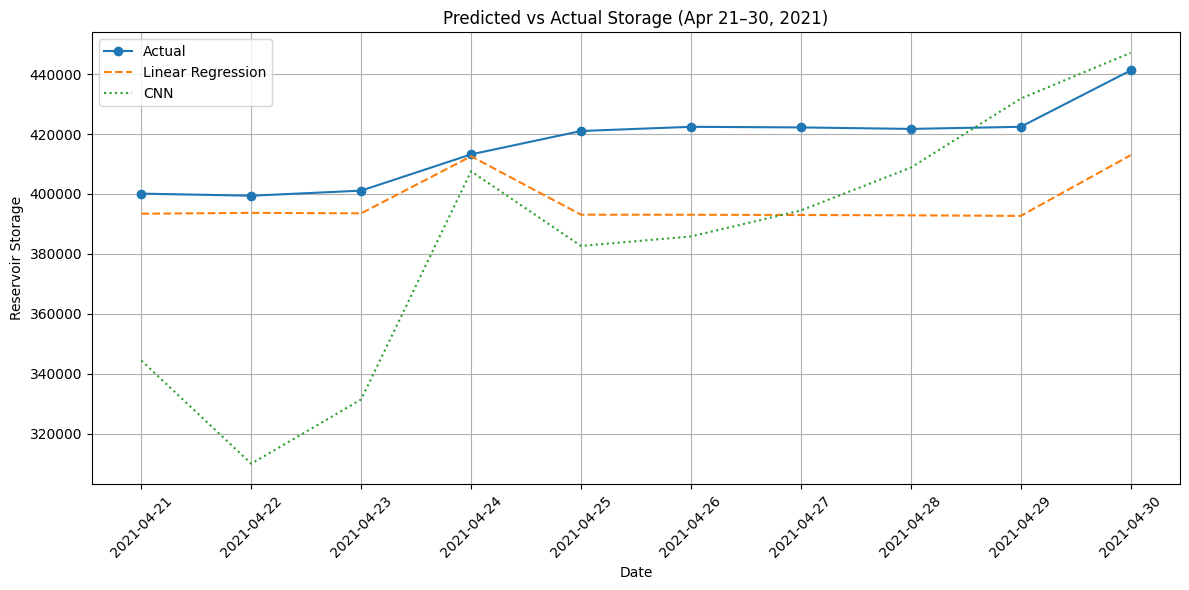

In [127]:
# data visualization - predictions
plt.figure(figsize=(12, 6))
plt.plot(test_df['datetime'], y_test, label='Actual', marker='o')
plt.plot(test_df['datetime'], y_pred_lr, label='Linear Regression', linestyle='--')
plt.plot(test_df['datetime'], y_pred_cnn, label='CNN', linestyle=':')
plt.xlabel('Date')
plt.ylabel('Reservoir Storage')
plt.title('Predicted vs Actual Storage (Apr 21–30, 2021)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [128]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
mape_cnn = mean_absolute_percentage_error(y_test, y_pred_cnn)

print("Linear Regression MAPE:", mape_lr)
print("CNN MAPE:", mape_cnn)


Linear Regression MAPE: 4.594973536039298
CNN MAPE: 8.6023168164604
